In [43]:
# Step 1: Install necessary libraries
# !pip install mmengine torch torchvision mmsegmentation matplotlib
import sys

sys.path.append("/home/mila/q/qian.yang/Light_Align/evaluation/ClearCLIP")
# Step 2: Import necessary modules
import torch
import random
from mmengine.config import Config
from mmengine.runner import Runner
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ClearCLIP.clearclip_segmentor as clearclip_segmentor

# import seg_eval

import matplotlib.colors as mcolors

list_path = (
    "/home/mila/q/qian.yang/Light_Align/evaluation/ClearCLIP/configs/cls_voc20.txt"
)
with open(list_path, "r") as file:
    lines = file.readlines()
    objects = {}
    for idx, line in enumerate(lines):
        objects[idx] = line.strip()
objects[255] = "background"
print(objects)

def generate_distinguishable_colors(n_colors=256):
    # Create a colormap with n distinct colors
    cmap = plt.get_cmap("hsv", n_colors)

    # Generate the colors
    colors = [cmap(i) for i in range(n_colors)]

    # Ensure unique color combinations by shuffling
    random.shuffle(colors)

    # Convert the RGB colors to hex, ignoring the alpha channel
    hex_colors = [
        "#%02x%02x%02x" % (int(r * 255), int(g * 255), int(b * 255))
        for r, g, b, _ in colors[:n_colors]
    ]

    return hex_colors


# Generate 256 distinct colors
colors_256 = generate_distinguishable_colors(256)
random.shuffle(colors_256)


# Convert hex to RGB and sort based on RGB values
def sort_hex_colors_by_rgb(hex_colors):
    rgb_colors = [(mcolors.hex2color(hex_color), hex_color) for hex_color in hex_colors]
    # Sort by RGB tuple
    rgb_colors.sort(key=lambda x: x[0])
    # Extract the sorted hex values
    sorted_hex_colors = [color[1] for color in rgb_colors]
    return sorted_hex_colors


def visualize_segmentation(img_tensor, seg_pred):
    """
    Visualize the segmentation result by showing the original image and predicted segmentation.
    Also, show a legend with object names and corresponding distinct colors outside the image.

    Args:
        img_tensor (torch.Tensor): The input image tensor of shape (C, H, W).
        seg_pred (torch.Tensor): The predicted segmentation mask of shape (H, W).
        object_names (dict): A dictionary mapping label indices to object names.
    """
    # Convert img_tensor from Tensor to NumPy and transpose to (H, W, C)
    img = img_tensor.transpose(1, 2, 0)

    # Convert segmentation prediction to NumPy
    seg_mask = seg_pred

    # Get unique labels from the segmentation mask
    unique_labels = np.unique(seg_mask)
    # print(unique_labels)
    # Map each label to a predefined color
    # random color
    label_to_color = {
        label: mcolors.hex2color(colors_256[label % 256]) for label in unique_labels
    }

    # Apply the custom color map to the segmentation mask
    seg_colored = np.zeros((*seg_mask.shape, 3))
    for label in unique_labels:
        seg_colored[seg_mask == label] = label_to_color[label]

    # Create a plot with two subplots: the original image and the segmentation result
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plot original image
    ax[0].imshow(img.astype(np.uint8))
    ax[0].axis("off")
    ax[0].set_title("Original Image")

    # Plot segmentation mask with distinct colors
    ax[1].imshow(seg_colored)
    ax[1].axis("off")
    ax[1].set_title("Segmentation Result")

    chosen_colors = []
    for label in unique_labels:
        chosen_colors.append(label_to_color[label])
    # sort chosen_colors based on the color
    chosen_colors = sort_hex_colors_by_rgb(chosen_colors)
    # re sort the unique_labels based on the chosen_colors
    unique_labels = sorted(
        unique_labels, key=lambda x: chosen_colors.index(label_to_color[x])
    )
    # Create a legend showing object names with corresponding colors
    handles = []
    for label in unique_labels:
        color_patch = mcolors.to_rgba(label_to_color[label])
        handles.append(
            plt.Line2D(
                [0],
                [0],
                marker="o",
                color="w",
                label=objects[label],
                markerfacecolor=color_patch,
                markersize=10,
            )
        )
    # handles resort based on the order of colo
    # Add the legend outside the plot
    ax[1].legend(
        handles=handles,
        loc="upper right",
        bbox_to_anchor=(1.5, 1),
        title="Legend",
        fontsize="small",
        ncol=2,
    )  # Set fontsize and column number

    # Adjust layout and show the result
    plt.tight_layout()
    plt.show()


SAIL_cfg_path = (
    "/home/mila/q/qian.yang/Light_Align/evaluation/ClearCLIP/configs/cfg_voc20.py"
)
ClearCLIP_cfg_path = "/home/mila/q/qian.yang/Light_Align/evaluation/ClearCLIP/configs/cfg_voc20_clearCLIP.py"
CLIP_cfg_path = (
    "/home/mila/q/qian.yang/Light_Align/evaluation/ClearCLIP/configs/cfg_ade20k_CLIP.py"
)

{0: 'aeroplane', 1: 'bicycle', 2: 'bird', 3: 'ship', 4: 'bottle', 5: 'bus', 6: 'car', 7: 'cat', 8: 'chair', 9: 'cow', 10: 'table', 11: 'dog', 12: 'horse', 13: 'motorbike', 14: 'person', 15: 'pottedplant', 16: 'sheep', 17: 'sofa', 18: 'train', 19: 'tvmonitor', 255: 'background'}


In [ ]:
cfg = Config.fromfile(SAIL_cfg_path)
cfg.launcher = "none"
cfg.work_dir = "/home/mila/q/qian.yang/Light_Align/segmentation"
cfg.model.text_model_name = "Alibaba-NLP/gte-large-en-v1.5"
cfg.model.vision_model_name = "facebook/dinov2-large"
cfg.model.head_weights_path = (
    "/home/mila/q/qian.yang/scratch/light_align/pytorch_model.bin"
)
cfg.model.linear_type = "star"
cfg.model.target_dimension = 1024
cfg.model.use_gmp = False
cfg.model.gmp_groups = 512
cfg.model.device = "cuda"
cfg.model.save_dir = "/home/mila/q/qian.yang/scratch/tmp"
cfg.model.precision = "fp32"
runner = Runner.from_cfg(cfg)
runner.model.to("cuda")

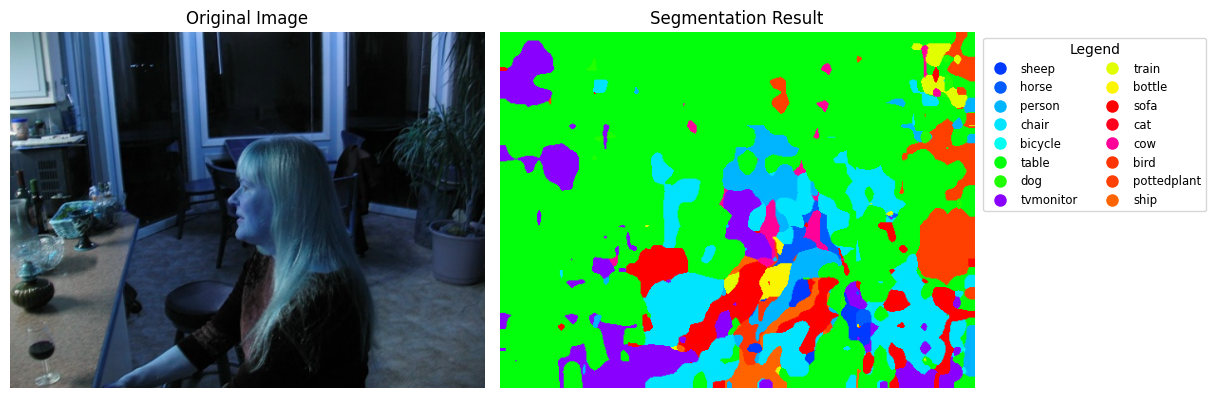

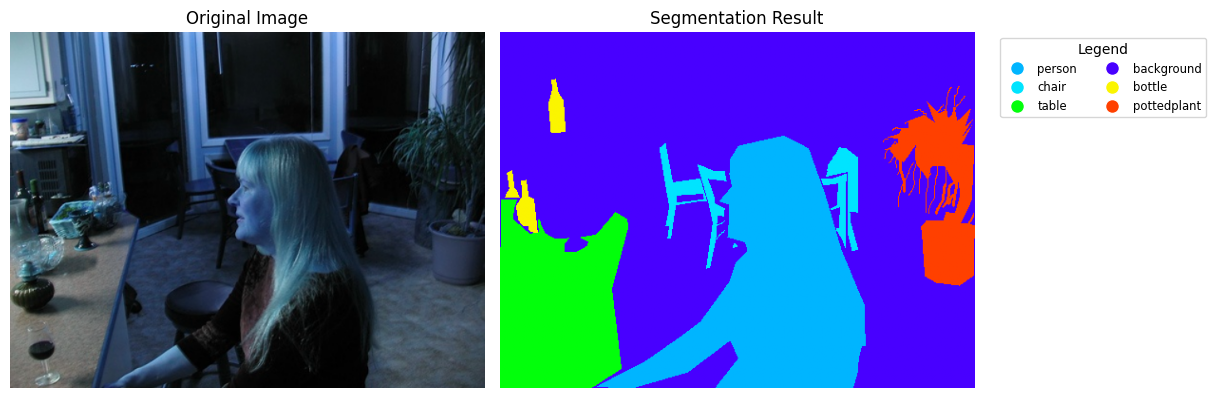

In [47]:
# Step 5: Load the image (you can modify the path to your test image)
random_index = 155
data = runner.test_dataloader.dataset[random_index]
original_img = data["inputs"].cpu().numpy()
oracle = runner.test_dataloader.dataset[random_index]["data_samples"].gt_sem_seg.data.squeeze(0)
data["inputs"] = [data["inputs"]]
data = runner.model.data_preprocessor(data, False)
img_tensor = torch.tensor(data["inputs"]).to("cuda")
seg_pred = runner.model.predict(
    img_tensor,
    data_samples=[runner.test_dataloader.dataset[random_index]["data_samples"]],
)
seg_pred = seg_pred[0].pred_sem_seg.data.cpu().numpy().squeeze(0)
visualize_segmentation(
    original_img,
    seg_pred,
)
visualize_segmentation(
    original_img,
    oracle.data.cpu().numpy(),
)

In [ ]:
ClearCLIP_cfg = Config.fromfile(ClearCLIP_cfg_path)
ClearCLIP_cfg.launcher = "none"
ClearCLIP_cfg.work_dir = "./segmentation"
ClearCLIP_runner = Runner.from_cfg(ClearCLIP_cfg)
ClearCLIP_runner.model.to("cuda")

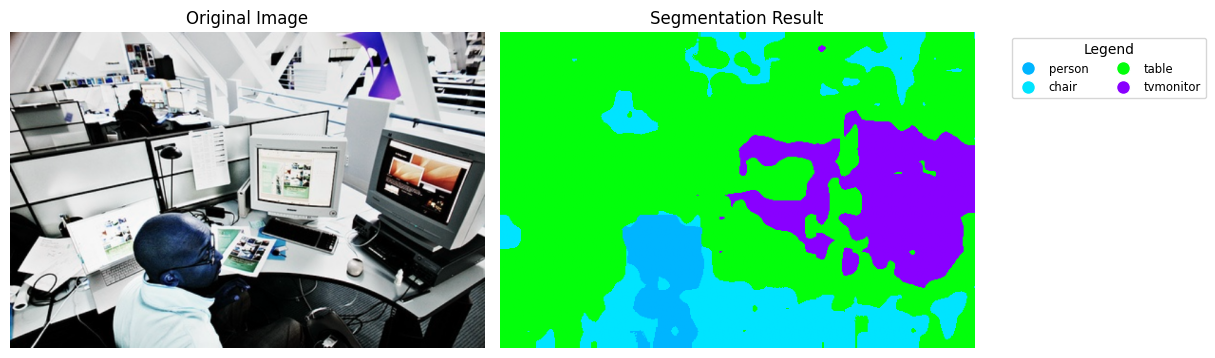

In [46]:
random_index = 55
data = ClearCLIP_runner.test_dataloader.dataset[random_index]
original_img = data["inputs"].cpu().numpy()
data["inputs"] = [data["inputs"]]
data = ClearCLIP_runner.model.data_preprocessor(data, False)
# print(data["inputs"].shape)
img_tensor = torch.tensor(data["inputs"]).to("cuda")
seg_pred = ClearCLIP_runner.model.predict(
    img_tensor,
    data_samples=[data["data_samples"]],
)
seg_pred = seg_pred[0].pred_sem_seg.data.cpu().numpy().squeeze(0)
visualize_segmentation(original_img, seg_pred)

In [ ]:
CLIP_cfg = Config.fromfile(CLIP_cfg_path)
CLIP_cfg.launcher = "none"
CLIP_cfg.work_dir = "./segmentation"
CLIP_runner = Runner.from_cfg(CLIP_cfg)
CLIP_runner.model.to("cuda")

09/26 22:22:05 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.


KeyError: 79

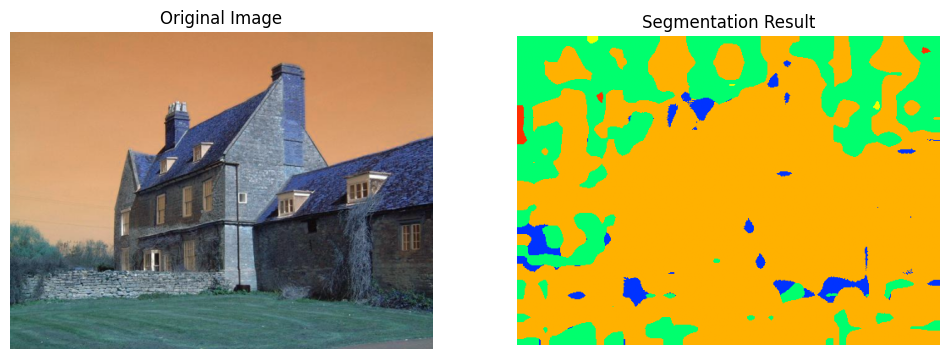

In [37]:
random_index = 0
data = CLIP_runner.test_dataloader.dataset[random_index]
original_img = data["inputs"].cpu().numpy()
data["inputs"] = [data["inputs"]]
data = CLIP_runner.model.data_preprocessor(data, False)
img_tensor = torch.tensor(data["inputs"]).to("cuda")
seg_pred = CLIP_runner.model.predict(
    img_tensor,
    data_samples=[runner.test_dataloader.dataset[random_index]["data_samples"]],
)
seg_pred = seg_pred[0].pred_sem_seg.data.cpu().numpy().squeeze(0)
visualize_segmentation(original_img, seg_pred)
